In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

In [13]:
image_size = (128,128)
batch_size = 20

training_data_dir = r'C:\Users\galhen400.CS.000\Downloads\Images\Images\Train'
validation_data_dir = r'C:\Users\galhen400.CS.000\Downloads\Images\Images\Validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 1607 images belonging to 20 classes.
Found 557 images belonging to 20 classes.


In [14]:
x_batch, y_batch = next(train_generator)

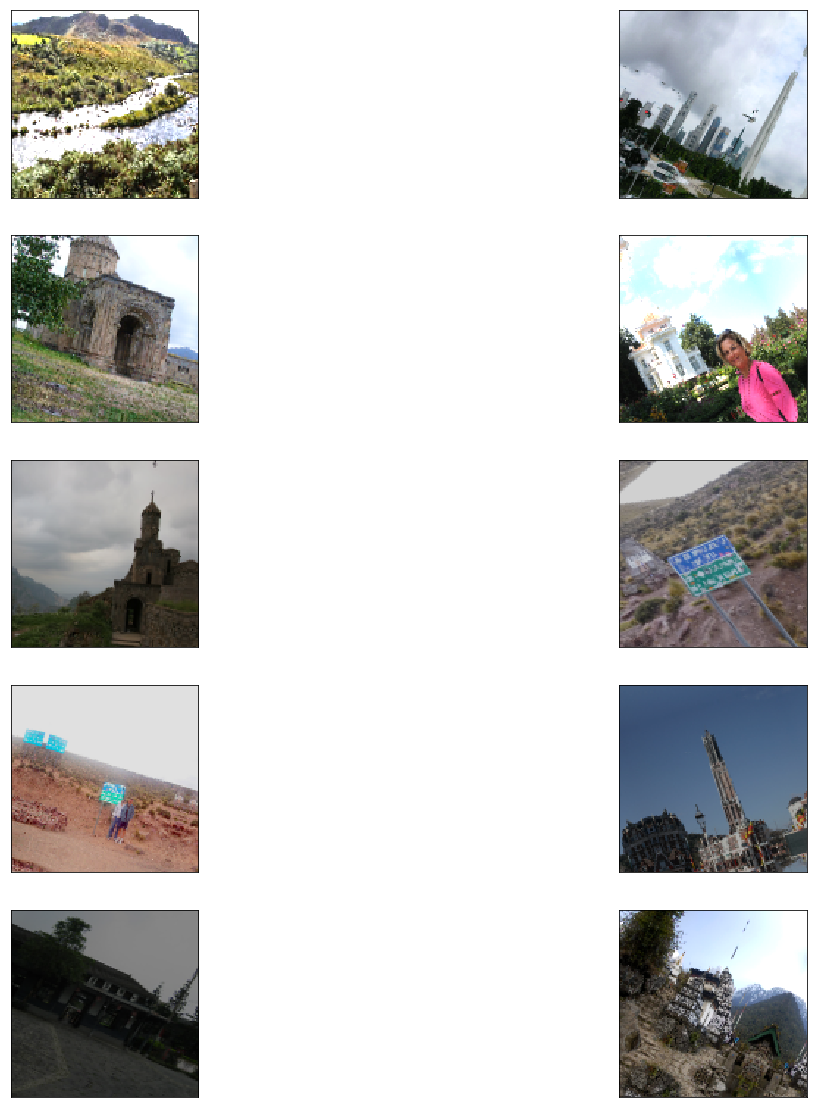

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [16]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [17]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

58892288/58889256 [==============================] - 22s 0us/step


In [18]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [19]:
for layer in base_model.layers[:]:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [20]:
for layer in base_model.layers[:]:
    layer.trainable = False

In [23]:
classCount = 20

x=base_model.output
x = Dropout(0.4, input_shape=(4,4,512))(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=MaxPooling2D(input_shape=(4,4,512),pool_size=(2,2),strides=(2,2))(x)
x = Dropout(0.4, input_shape=(4,4,512))(x)
x=Flatten()(x)
preds=Dense(classCount,activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)

In [24]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [25]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

In [26]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

80


In [27]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossAccHistory()

In [28]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=8
                   ,callbacks = [history])

Epoch 1/8
80/80 [==============================] - 188s 2s/step - loss: 2.3059 - acc: 0.3306 - val_loss: 1.2205 - val_acc: 0.6984
Epoch 2/8
80/80 [==============================] - 192s 2s/step - loss: 1.1494 - acc: 0.6826 - val_loss: 0.7902 - val_acc: 0.7648
Epoch 3/8
80/80 [==============================] - 195s 2s/step - loss: 0.7994 - acc: 0.7625 - val_loss: 0.6112 - val_acc: 0.8133
Epoch 4/8
80/80 [==============================] - 191s 2s/step - loss: 0.6550 - acc: 0.7972 - val_loss: 0.5490 - val_acc: 0.8420
Epoch 5/8
80/80 [==============================] - 194s 2s/step - loss: 0.5507 - acc: 0.8300 - val_loss: 0.4631 - val_acc: 0.8689
Epoch 6/8
80/80 [==============================] - 192s 2s/step - loss: 0.5089 - acc: 0.8439 - val_loss: 0.4182 - val_acc: 0.8851
Epoch 7/8
80/80 [==============================] - 192s 2s/step - loss: 0.4395 - acc: 0.8669 - val_loss: 0.4940 - val_acc: 0.8366
Epoch 8/8
80/80 [==============================] - 192s 2s/step - loss: 0.3763 - acc: 0.89

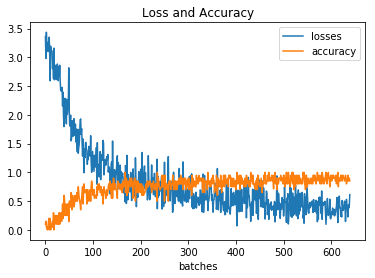

In [29]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

In [30]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

In [31]:
import time

networkfileName = "C:\ML666\\vgg16_v2.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [32]:
history = LossAccHistory()
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [history, checkpoint, early])

Epoch 1/5
79/80 [============================>.] - ETA: 1s - loss: 0.3662 - acc: 0.8937
Epoch 00001: val_acc improved from -inf to 0.89587, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3666 - acc: 0.8937 - val_loss: 0.3541 - val_acc: 0.8959
Epoch 2/5
79/80 [============================>.] - ETA: 1s - loss: 0.3487 - acc: 0.8944
Epoch 00002: val_acc improved from 0.89587 to 0.90305, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3499 - acc: 0.8945 - val_loss: 0.3315 - val_acc: 0.9031
Epoch 3/5
79/80 [============================>.] - ETA: 1s - loss: 0.3320 - acc: 0.8968
Epoch 00003: val_acc did not improve from 0.90305
80/80 [==============================] - 194s 2s/step - loss: 0.3296 - acc: 0.8981 - val_loss: 0.3580 - val_acc: 0.8941
Epoch 4/5
79/80 [============================>.] - ETA: 1s - loss: 0.2915 - acc: 0.9052
Epoch 00004: val_acc did not improve from 0.90305
80/80 [

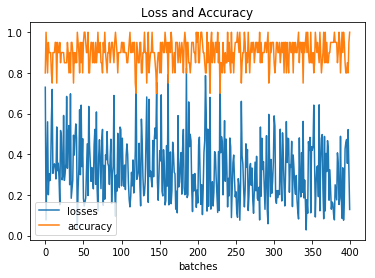

In [33]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# The directory of KNN train data
data_dir = r'C:\Users\galhen400.CS.000\Downloads\Images\Images\Train'

# The neural network model into base_model
base_model = load_model('C:\ML666\\vgg16_v2.h5')

# Cut the customized layers from the read resnet algorithm
x=base_model.get_layer('max_pooling2d_1').output

# Eport network to one dimension
vector=Flatten()(x)

# Make the model with the whole network as input and the vector as output
model = Model(inputs=base_model.input, outputs=vector)

datagen = ImageDataGenerator()     # Creating the Data generator

# Generator from the images
generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',  # only data, no labels
        shuffle=False)  # keep data in same order as label

Found 1607 images belonging to 20 classes.


In [39]:
import numpy as np

imgsList = []
proccImgs = []
labels = []

# For each image in the generator
for i in range(generator.n):
    (img, lbl) = generator.next();
    
    # Adding the image to the list of images
    imgsList.append(img)
    
    # Adding the proccessed images to the list of processed imaged
    proccImgs.append(np.reshape(model.predict_on_batch(img), -1))
    
    # Adding the image labels to list of labels
    labels.append(np.argmax(lbl))
    
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [40]:
print(imgsList)

[array([[[[231., 229., 230.],
         [232., 228., 229.],
         [232., 230., 231.],
         ...,
         [211., 223., 235.],
         [218., 226., 239.],
         [218., 232., 243.]],

        [[233., 231., 232.],
         [230., 228., 229.],
         [235., 233., 234.],
         ...,
         [211., 223., 237.],
         [213., 226., 242.],
         [219., 227., 240.]],

        [[231., 229., 230.],
         [233., 231., 232.],
         [238., 236., 237.],
         ...,
         [220., 228., 241.],
         [211., 223., 237.],
         [213., 227., 236.]],

        ...,

        [[102.,  93.,  96.],
         [122., 124., 121.],
         [119., 122., 115.],
         ...,
         [  4.,  20.,  35.],
         [  0.,   4.,  16.],
         [  1.,  17.,  16.]],

        [[119., 115., 114.],
         [114., 114., 114.],
         [149., 128., 125.],
         ...,
         [ 15.,  41.,  38.],
         [ 85., 101., 114.],
         [ 49.,  62.,  68.]],

        [[ 26.,  13.,  30.],
      

In [41]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)

# Fit with KNN algorithm with the proccessed images and labels
neigh.fit(proccImgs, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [56]:
test_datagen = ImageDataGenerator()     # Creating the Data generator
validation_data_dir = r'C:\Users\galhen400.CS.000\Downloads\Images\Images\Validation'

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                        target_size=(128, 128),
                                        batch_size=1,
                                        color_mode='rgb',
                                        class_mode = "categorical",
                                        shuffle=True)
x_img, y_label = next(validation_generator);
features = model.predict(x_img)

Found 557 images belonging to 20 classes.


In [57]:
print(x_img)

[[[[200. 217. 224.]
   [203. 218. 225.]
   [206. 221. 228.]
   ...
   [195. 204. 201.]
   [197. 206. 203.]
   [194. 205. 201.]]

  [[197. 214. 221.]
   [205. 220. 227.]
   [204. 219. 226.]
   ...
   [205. 211. 207.]
   [211. 217. 213.]
   [209. 218. 213.]]

  [[199. 218. 225.]
   [205. 220. 227.]
   [209. 222. 228.]
   ...
   [214. 224. 216.]
   [226. 231. 225.]
   [227. 233. 229.]]

  ...

  [[126. 108.  84.]
   [ 80.  62.  38.]
   [124. 107.  79.]
   ...
   [131. 115.  90.]
   [128. 108.  81.]
   [118. 104.  77.]]

  [[114.  94.  67.]
   [123. 103.  79.]
   [121. 101.  74.]
   ...
   [123. 108.  85.]
   [128. 111.  85.]
   [121. 107.  81.]]

  [[113.  93.  68.]
   [120.  96.  68.]
   [118.  98.  71.]
   ...
   [118. 104.  78.]
   [124. 108.  83.]
   [108.  92.  69.]]]]


In [58]:
x_img.size

49152

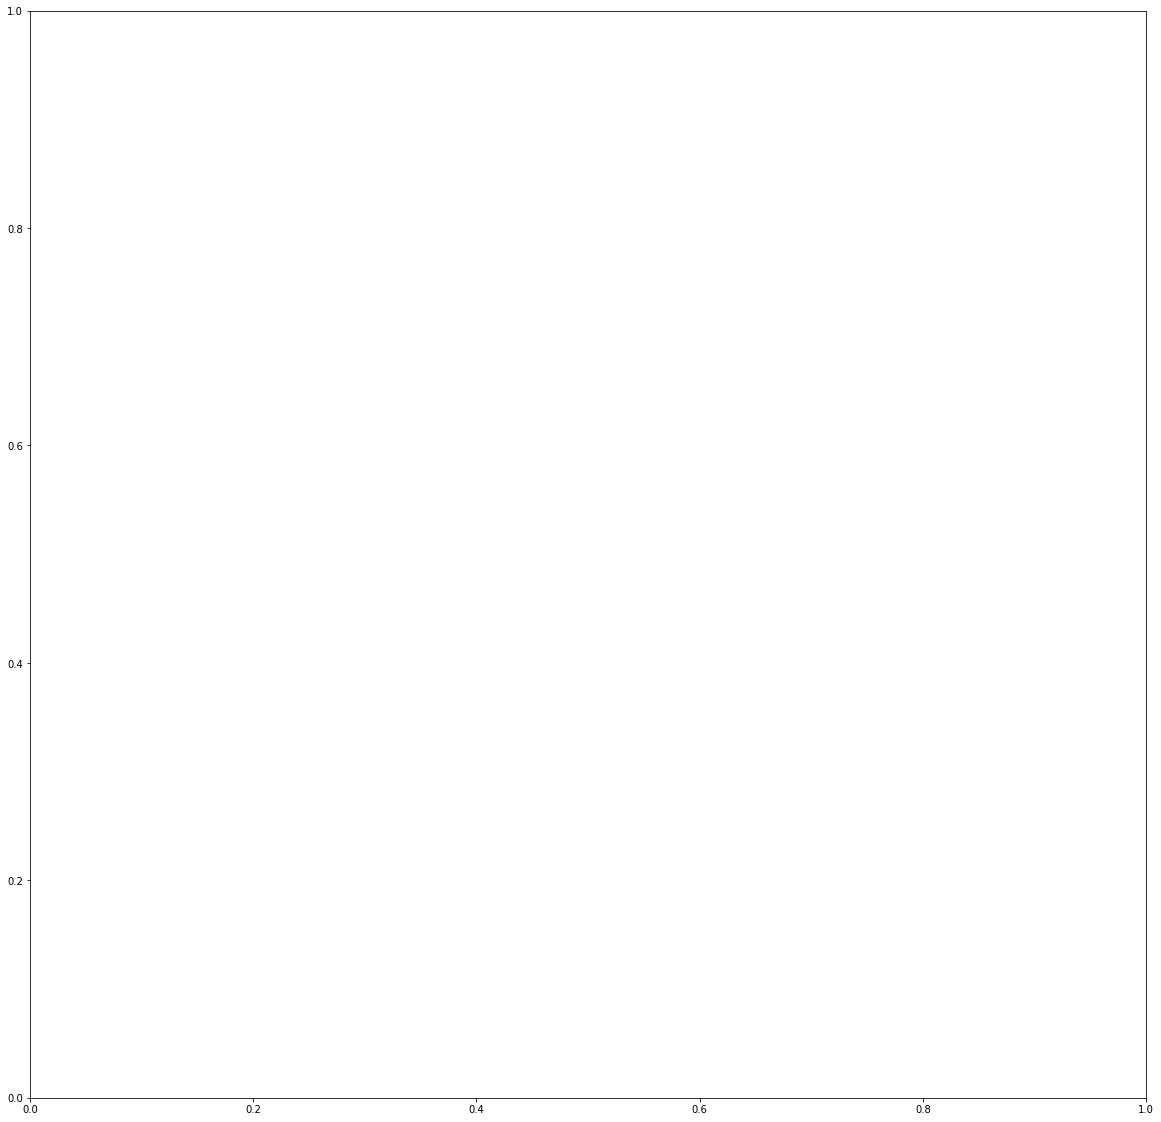

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.subplot(1,1,1)
image = x_img

In [60]:
image= image.astype(int)
image = np.reshape(image, (128, 128, 3))

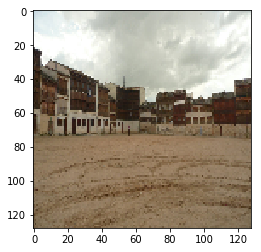

In [61]:
plt.imshow(image)

In [62]:
labels = neigh.kneighbors(features, return_distance=False) 

print(labels[0])

[1374 1428 1438 1399 1404 1432 1442 1398  139  127]


[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]
[1374 1428 1438 1399 1404 1432 1442 1398  139  127]


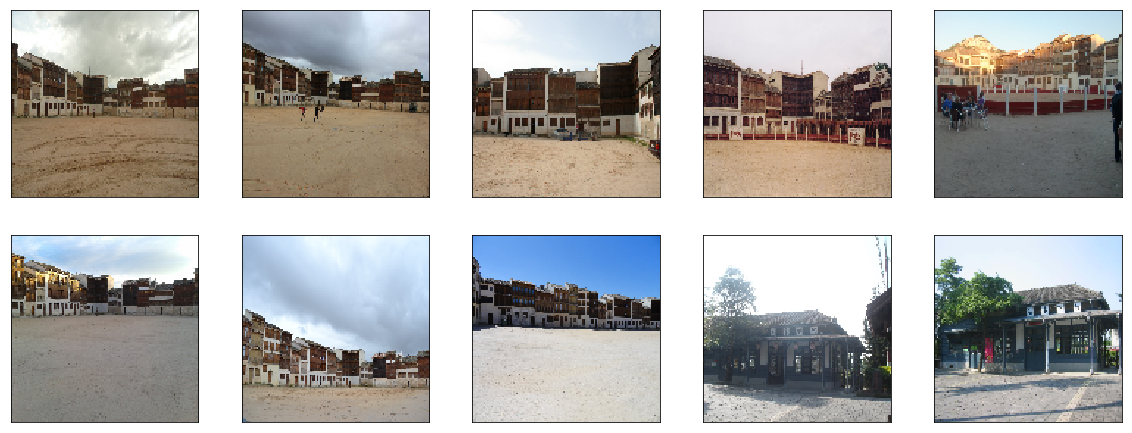

In [63]:
plt.figure(figsize=(20, 20))
for j in range(10):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = imgsList[labels[0][j]]
    image= image.astype(int)
    image = np.reshape(image, (128, 128, 3))
    plt.imshow(image)
    print(labels[0])